<a href="https://colab.research.google.com/github/ShaelinN/GameOutcomePrediction/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np

In [6]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
root = "/content/drive/MyDrive/COMP721_Project"

In [3]:
data = os.path.join(root, "Data")

#preprocessing

In [30]:
player_rs_career = pd.read_csv(os.path.join(data, "player_regular_season_career.csv"))
player_rs_career.head()

,ilkid,firstname,lastname,leag,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
0,ABDELAL01,Alaa,Abdelnaby,N,256,3200,1465,283,563,846,85,71,69,247,484,1236,620,321,225,3,0
1,ABDULKA01,Kareem,Abdul-jabbar,N,1560,57446,38387,2975,9394,17440,5660,1160,3189,2527,4657,28307,15837,9304,6712,18,1
2,ABDULMA01,Mahmo,Abdul-rauf,N,586,15633,8553,219,868,1087,2079,487,46,963,1107,7943,3514,1161,1051,1339,474
3,ABDULTA01,Tariq,Abdul-wahad,N,236,4808,1830,275,501,776,266,184,82,309,485,1726,720,529,372,76,18
4,ABDURSH01,Shareef,Abdur-rahim,N,672,24862,13338,1498,3976,5474,1847,718,556,1911,1845,10215,4789,4427,3614,477,146


In [79]:
player_keys = player_rs_career.loc[:,:"leag"]


Dn_player_vecs = player_rs_career.loc[:,"gp":]

pca = PCA(n_components=2)
D2_player_vecs = pca.fit_transform(Dn_player_vecs)


#Models

In [80]:
player_summary = player_keys.copy()

OCSVM = svm.OneClassSVM(nu=0.08)
IF = IsolationForest(contamination=0.02)
EE = EllipticEnvelope(contamination=0.08)

model = IF #change to OCSVM, IF, or EE

working_player_vecs = Dn_player_vecs #change to D2_player_vecs or Dn_player_vecs

In [81]:
working_player_vecs = working_player_vecs.copy()

In [82]:
detected_outliers = model.fit_predict(working_player_vecs)
player_summary["outlier"] = detected_outliers
player_summary.head()

,ilkid,firstname,lastname,leag,outlier
0,ABDELAL01,Alaa,Abdelnaby,N,1
1,ABDULKA01,Kareem,Abdul-jabbar,N,-1
2,ABDULMA01,Mahmo,Abdul-rauf,N,1
3,ABDULTA01,Tariq,Abdul-wahad,N,1
4,ABDURSH01,Shareef,Abdur-rahim,N,1


#Plotting

In [88]:
# outlier
C_0 = np.argwhere(detected_outliers==-1)
C_0 = D2_player_vecs[C_0]   #since in plotting, only work with D2 vectors (2D)
C_0 = C_0.transpose() 

In [89]:
#inlier
C_1 = np.argwhere(detected_outliers==1)
C_1 = D2_player_vecs[C_1]   #since in plotting, only work with D2 vectors (2D)
C_1 = C_1.transpose()

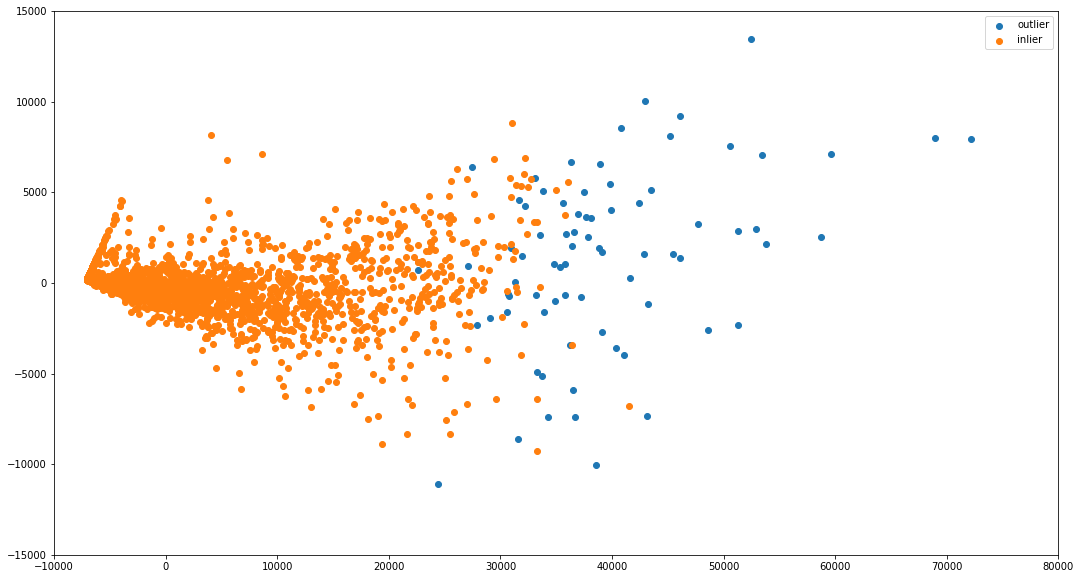

In [90]:
plt.figure(figsize=(18,10))

plt.scatter(C_0[0], C_0[1], label='outlier') #outlier
plt.scatter(C_1[0], C_1[1], label='inlier')

plt.xlim(-10000,80000)
plt.ylim(-15000,15000)
plt.legend()

#Informal Evaluation

this is not a true evaluation, since the metrics used do not apply in the case of unsupervised learning. Rather, it checks for correlation between those players rated outlier and those who at some time were in the all-stars.

In [91]:
player_all_star= pd.read_csv(os.path.join(data, "player_allstar.csv"))
player_all_star.head()
player_all_star["ilkid"] = [i.upper().strip() for i in player_all_star["ilkid"]]

In [92]:
count = player_all_star[["ilkid"]].groupby("ilkid", as_index=False).size()
count.columns = ["ilkid","times_allstar"]

In [93]:
player_summary = pd.merge(player_summary, count,how="left", on="ilkid")
player_summary["times_allstar"] = player_summary["times_allstar"].fillna(0)
player_summary

,ilkid,firstname,lastname,leag,outlier,times_allstar
0,ABDELAL01,Alaa,Abdelnaby,N,1,0.0
1,ABDULKA01,Kareem,Abdul-jabbar,N,-1,19.0
2,ABDULMA01,Mahmo,Abdul-rauf,N,1,0.0
3,ABDULTA01,Tariq,Abdul-wahad,N,1,0.0
4,ABDURSH01,Shareef,Abdur-rahim,N,1,1.0
...,...,...,...,...,...,...
3754,ZEVENPH01,Phil,Zevenbergen,N,1,0.0
3755,ZIDEKGE01,George,Zidek,N,1,0.0
3756,ZOETJI01,Jim,Zoet,N,1,0.0
3757,ZOPFBI01,Bill,Zopf,N,1,0.0


##what proportion of players were in allstars?


In [94]:
stars = player_summary.where(player_summary["times_allstar"] != 0).dropna()

stars.shape[0]/player_summary.shape[0]


0.12476722532588454

##what proportion of inliers were in allstars?

In [95]:
inliers = player_summary.where(player_summary["outlier"] == 1).dropna()

stars = inliers.where(inliers["times_allstar"] != 0).dropna()


stars.shape[0]/inliers.shape[0]


0.10779256041270703

##what proportion of outliers were in allstars?

In [96]:
outliers = player_summary.where(player_summary["outlier"] == -1).dropna()

stars = outliers.where(outliers["times_allstar"] != 0).dropna()


stars.shape[0]/outliers.shape[0]


0.9473684210526315